(tutorial_fairml)=

# Fairness-Aware Classification

In this tutorial we will explore several fairness-aware machine learning techniques that can be used to enforce fairness constraints of a machine learning model.

---

**Learning Objectives**. After this tutorial you will be able to:
* apply techniques for fairness-aware classification in Python;
* examine strengths and limitations of fairness-aware classification techniques;

--- 

```{warning}
Although the goal of this tutorial is to showcase fair-ml approaches, **a data scientist's first actions should always include scrutinizing the need for machine learning, the machine learning task formulation, and data collection practices.**  Especially in a sensitive application such as pre-trial risk assesment. Often, enforcing fairness constraints via fairness-aware machine learning does not lead to meaningful mitigation of fairness-related harm.
```

---

## COMPAS: A Pre-Trial Risk Assessment Tool
COMPAS is a decision support tool used by courts in the United States to assess the likelihood of a defendant becoming a recidivist; i.e., relapses into criminal behavior. In particular, COMPAS risk scores are used in **pre-trial risk assessment**.

```{admonition} What is pre-trial risk assessment in the US judicial system?
After somebody has been arrested, it will take some time before they go to trial. The primary goal of pre-trial risk assessment is to determine the likelihood that the defendant will re-appear in court at their trial. Based on the assessment, a judge decides whether a defendent will be detained or released while awaiting trial. In case of release, the judge also decides whether bail is set and for which amount. Bail usually takes the form of either a cash payment or a bond. If the defendant can't afford to pay the bail amount in cash - which can be as high as \$50,000 - they can contract a bondsmen. For a fee, typically around 10\% of the bail, the bondsmen will post the defendant's bail.

If the defendant can afford neither bail nor a bail bond, they have to prepare for their trial while in jail. [This](https://eu.clarionledger.com/story/opinion/columnists/2020/05/28/cant-afford-bail-woman-describes-experience-mississippi-bail-fund-collective/5257295002/) [is](https://medium.com/dose/bail-is-so-expensive-it-forces-innocent-people-to-plead-guilty-72a3097a2ebe) [difficult](https://facctconference.org/2018/livestream_vh210.html). The time between getting arrested and a bail hearing can take days, weeks, months, or even years. In some cases, the decision is between pleading guilty and going home. Consequently, people who cannot afford bail are much more likely to plead guilty to a crime they did not commit. Clearly, a (false) positive decision of the judge will have a big impact on the defendant's prospects. 

On the other extreme, false negatives could mean that dangerous individuals are released into society and do not show up for their trial.
```

Proponents of risk assessment tools argue that they can lead to more efficient, less biased, and more consistent decisions compared to human decision makers. However, concerns have been raised that the scores can replicate historical inequalities.

### Propublica's Analysis of COMPAS
In May 2016, investigative journalists of Propublica released a critical analysis of COMPAS. **Propublica's assessment: COMPAS wrongly labeled black defendants as future criminals at almost twice the rate as white defendants**, while white defendants were mislabeled as low risk more often than black defendants ([Propublica, 2016](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)). 

The analysis of COMPAS is likely one of the most well-known examples of algorithmic bias assessments. Within the machine learning research community, the incident sparked a renewed interest in fairness of machine learning models.

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib

# other
import sklearn
import fairlearn
import torch

# this tutorial has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.24.4  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.8.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.1   Your version: %s" % sklearn.__version__)
print("fairlearn     Tested version: 0.10.0  Your version: %s" % fairlearn.__version__)
print("torch         Tested version: 2.2.1   Your version: %s" % torch.__version__)

pandas        Tested version: 2.0.3   Your version: 2.0.3
numpy         Tested version: 1.24.4  Your version: 1.24.4
matplotlib    Tested version: 3.5.3   Your version: 3.5.1
scikit-learn  Tested version: 1.3.2   Your version: 1.2.1
fairlearn     Tested version: 0.10.0  Your version: 0.10.0
torch         Tested version: 1.13.1  Your version: 2.2.1


In [2]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay

# fairlearn
from fairlearn.metrics import (
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    MetricFrame,
    equalized_odds_difference,
)
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.adversarial import AdversarialFairnessClassifier

## Load and Pre-Process Data

You can download the data set collected by ProPublica [here](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv). As in the previous tutorial, we pre-process the data similar to ProPublica and select all instances related to Caucasian and African-American defendants. As we intend to train a new classifier, we split the data into a training and test set.

In [3]:
# load data
df = pd.read_csv("compas-scores-two-years.csv")
# filter similar to propublica
df = df[
    (df["days_b_screening_arrest"] <= 30)
    & (df["days_b_screening_arrest"] >= -30)
    & (df["is_recid"] != -1)
    & (df["c_charge_degree"] != "O")
    & (df["score_text"] != "N/A")
]
# select two largest groups
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]
# select columns
df = df[
    [
        "sex",
        "age",
        "race",
        "priors_count",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "two_year_recid",
    ]
]
# convert categorical variables to numerical to make suitable for ML model
df = pd.get_dummies(df, drop_first=True)
# define X and y
X = df.drop("two_year_recid", axis=1)
y = df["two_year_recid"]

# split the data in train-validation-test sets; use random_state for reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# save sensitive features and drop from X
sensitive_features_train = X_train["race_Caucasian"].copy()
sensitive_features_val = X_val["race_Caucasian"].copy()
sensitive_features_test = X_test["race_Caucasian"].copy()
X_train = X_train.drop("race_Caucasian", axis=1)
X_val = X_val.drop("race_Caucasian", axis=1)
X_test = X_test.drop("race_Caucasian", axis=1)

# inspect dataset
display(X_train.head())
# proportion of positives
print("proportion of positives (train): %.2f" % y_train.mean())

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,sex_Male
1054,53,2,0,0,0,True
731,36,4,0,0,0,False
5827,56,3,0,0,0,False
44,29,0,0,0,0,True
4475,27,2,0,0,0,True


proportion of positives (train): 0.47


The data now contains the following features:
* *age*. The defendant's age on the COMPAS screening date. 
* *priors_count*. The number of prior charges up to but not including the current offense.
* *juv_fel_count*. The number of prior charges for juvenile fellonies up to but not including the current offense.
* *juv_misd_count*. The number of prior charges for juvenile misdemeanors up to but not including the current offense.
* *juv_other_count*. The number of prior charges for other juvenile offenses up to but not including the current offense.
* *sex_Male*. The defendant's sex, measured as US census sex categories (either 1 for *Male* or 0 for *Female*).

The proportion of positives in the data set is almost 0.5, which means that the dataset is balanced in terms of positives/negatives. This makes **accuracy** a (somewhat) suitable metric for measuring the overall predictive performance of our models.

### Equalized Odds
In this tutorial, we will attempt to train a **new classifier** for predicting recidivism with similar error rates across racial groups.


```{admonition} Equalized Odds
**Equalized Odds** holds if, for all values of $y$ and $a$, $$P(\hat{Y} = y | A = a, Y = y) = P(\hat{Y} = y | A = a', Y = y)$$ where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.
```

In other words, the **false positive rate** and **false negative rate** should be equal across groups. As explained before, a false positive prediction in pre-trial risk assessment can have large consequences for the involved defendant, as they may have to await trial in jail. This may even result in the defendant pleading guilty to a crime they did not commit. On the other extreme, false negatives could mean that dangerous individuals are released into society.

In [4]:
def score(
    y_train,
    y_train_pred,
    y_val,
    y_val_pred,
    sensitive_features_train,
    sensitive_features_val,
    metrics={"accuracy": accuracy_score, "fpr": false_positive_rate, "fnr": false_negative_rate,},
):
    """
    Helper function to evaluate classifiers without too much repetition of code.
    """

    # training set
    mf_train = MetricFrame(
        metrics=metrics,
        y_true=y_train,
        y_pred=y_train_pred,
        sensitive_features=sensitive_features_train,
    )

    # validation set
    mf_val = MetricFrame(
        metrics=metrics,
        y_true=y_val,
        y_pred=y_val_pred,
        sensitive_features=sensitive_features_val,
    )

    # display results
    display(
        pd.concat(
            [mf_train.by_group, mf_val.by_group], keys=["train", "validation"]
        ).unstack(level=0)
    )

    # compute metrics
    print(
        "equalized odds difference (validation): %.2f"
        % equalized_odds_difference(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=sensitive_features_val,
        )
    )
    print("accuracy (validation): %.2f" % accuracy_score(y_true=y_val, y_pred=y_val_pred))
    return

## Classification without Fairness Constraints

First, let's train a simple logistic regression classifier on the data and see how it performs on the validation set.

In [5]:
# Train simple logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# score
score(
    y_train,
    lr.predict(X_train),
    y_val,
    lr.predict(X_val),
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.682209   0.659878  0.288462   0.275000  0.343884   0.402390
True            0.670707   0.644518  0.151214   0.151163  0.607945   0.627907

equalized odds difference (validation): 0.23
accuracy (validation): 0.65


The validation set accuracy of our classifier is approximately the same for African-Americans (0.66) and Caucasians (0.64). However, the FNR and FPR differ substantially, indicating that African-Americans are more often falsely predicted to recidivise, whereas Caucasians are more often falsely predicted to *not* recidivise. This disparity is reflected in the computed equalized odds difference (0.23).

## Fairness-Aware Machine Learning
There exist several technical approaches to explicitly incorporate fairness constraints in a machine learning model. We can roughly distinguish three types of approaches:
* **Pre-processing** algorithms adjust training data directly to mitigate downstream model unfairness. 
* **Constrained learning** approaches incorporate fairness constraints into the machine learning process, either by directly incorporating a constraint in the loss function or by learning an ensemble of predictors.
* **Post-processing** techniques make adjustments to existing machine learning models to satisfy fairness constraints, either by adjusting the parameters of a trained model directly or by post-processing the predictions of the model.

## Manually Post-Processing the Decision Threshold
In our previous model, we have simply applied the default decision threshold of 0.5 for both African-Americans and Caucasians. One way to account for differences in FPR and FNR is to **choose a separate threshold for each sensitive group**. Note that this implies that **different groups are held to a different standard**.

We will now choose a new decision threshold for African-Americans to ensure that the FPR of African-Americans is equal to the FPR of Caucasians. In our previous model, the FPR in the training set is approximately 0.15 for Caucasians. We use this as our target FPR for African-American defendants.

In [6]:
# make scoring predictions
y_train_score_lr = pd.Series(lr.predict_proba(X_train)[:, 1], index=X_train.index)
y_val_score_lr = pd.Series(lr.predict_proba(X_val)[:, 1], index=X_val.index)

# get indices for grouping
idx_AA_train = sensitive_features_train[sensitive_features_train==0].index

# get new thresholds based on ROC curve for AA
fpr_AA_train, tpr_AA_train, thresholds_AA_train = roc_curve(
    y_true=y_train[idx_AA_train], y_score=y_train_score_lr[idx_AA_train]
)
new_thr = thresholds_AA_train[(np.abs(fpr_AA_train - 0.15)).argmin()]

print("New decision threshold for African-Americans: %.2f" % new_thr)

New decision threshold for African-Americans: 0.59


Based on the validation data, we have computed that a decision threshold of 0.59 would lead to a FPR of approximately 0.15.

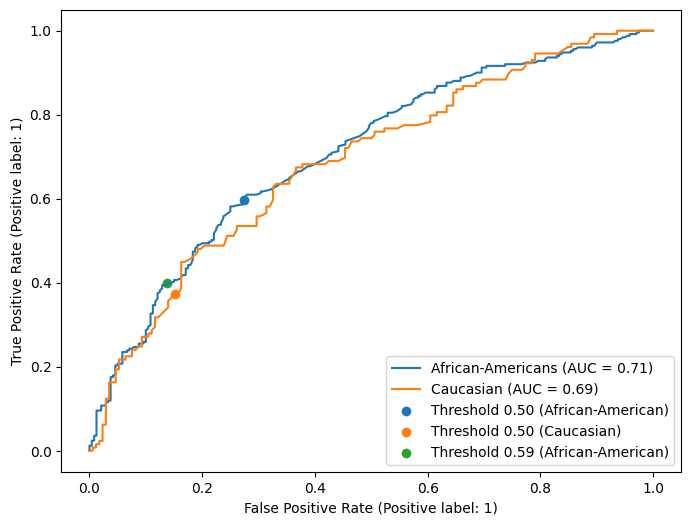

In [7]:
# get remaining indices for grouping
idx_AA_val = sensitive_features_val[sensitive_features_val==0].index
idx_C_val = sensitive_features_val[sensitive_features_val==1].index
idx_C_train = sensitive_features_train[sensitive_features_train==1].index

# plot ROC curves
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

RocCurveDisplay.from_estimator(
    lr,
    X_val.loc[idx_AA_val, :],
    y_val.loc[idx_AA_val],
    name="African-Americans",
    ax=ax,
)

RocCurveDisplay.from_estimator(
    lr,
    X_val.loc[idx_C_val, :],
    y_val.loc[idx_C_val],
    name="Caucasian",
    ax=ax,
)

# add thresholds
plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= 0.5
    ),
    true_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= 0.5
    ),
    label="Threshold 0.50 (African-American)",
)
plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_C_val], y_pred=y_val_score_lr[idx_C_val] >= 0.5
    ),
    true_positive_rate(
        y_true=y_val[idx_C_val], y_pred=y_val_score_lr[idx_C_val] >= 0.5
    ),
    label="Threshold 0.50 (Caucasian)",
)

plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= new_thr
    ),
    true_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= new_thr
    ),
    label="Threshold %.2f (African-American)" % new_thr,
)

plt.legend(loc="lower right")
plt.show()

This plot visualizes the results of our manual selection approach on the test data. We have plotted the ROC curve for each racial group separately. The original decision threshold of 0.5 resulted in higher TPR and FPR for African-Americans. By choosing a different threshold for this group, we end up on a point on the ROC curve that is much closer to the FPR and TPR of Caucasians.

Now let's evaluate the performance of the new group-specific decision thresholds on the validation set.

In [8]:
# make new predictions at two separate decision thresholds
y_train_pred_lr_m = pd.concat(
    [y_train_score_lr[idx_AA_train] >= new_thr, y_train_score_lr[idx_C_train] >= 0.5]
).reindex(X_train.index)

y_val_pred_lr_m = pd.concat(
    [y_val_score_lr[idx_AA_val] >= new_thr, y_val_score_lr[idx_C_val] >= 0.5]
).reindex(X_val.index)

# score
score(
    y_train,
    y_train_pred_lr_m,
    y_val,
    y_val_pred_lr_m,
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.639203   0.625255  0.149038   0.137500  0.549187   0.601594
True            0.670707   0.644518  0.151214   0.151163  0.607945   0.627907

equalized odds difference (validation): 0.03
accuracy (validation): 0.63


As can be seen from this table, we have been able to substantially reduce equalized odds difference (decreased from 0.23 to 0.03), with similar overall accuracy (decreased from 0.65 to 0.63).

## Randomized Decision Thresholds Using `ThresholdOptimizer` 
In addition to manual optimization, it is also possible to automatically determine group-specific decision thresholds. The class `fairlearn.postprocessing.ThresholdOptimizer` is based on the algorithm introduced by [Hardt. et al (2016)](https://papers.nips.cc/paper/2016/hash/9d2682367c3935defcb1f9e247a97c0d-Abstract.html). 

```{admonition} Group-Specific Randomized Thresholds
Equalized odds requires us to set the false positive rate and true positive rate equal across groups. Through group-specific decision thresholds, we can take any point on the group-specific ROC curve, which increases allows us to get a more similar FPR and FNR for both groups. However, group-specific thresholds still limit us to the (FPR, TPR) combinations that lie on the intersection of the group-specific ROC curves. In some cases, the group-specific ROC curves may not intersect or represent a poor trade-off between false positives and false negatives. To further increase the solution space, the `ThresholdOptimizer` allows the group-specific decision thresholds to be **randomized**: we randomly pick between two distinct thresholds.

The probability $p_a$ with which we choose one threshold over the other determines which (fpr,tpr) combination in the ROC space we end up with. By carefully selecting the decision thresholds and probabilities $p_a$, we can end up with a combination that is also on the group-specific ROC-curve of the worst-off group, satisfying equalized odds. The point on the ROC curve at which randomization is aimed, is optimized such that the disparity is the smallest, while predictive performance is the highest.

Note that using this algorithm has the following implications:
* The predictive performance for each group is decreased until it is equal to that of the worst-off group.
* Due to randomization, two individuals with the exact same characteristics may receive a different classification.
```

The `ThresholdOptimizer` class has the following parameters: 
* `estimator`: the (fitted) classifier
* `constraints` : the fairness constraint for which we want to optimize, we can choose between `'demographic_parity'`, `'equalized odds'`, `'false_positive_rate_parity'` `'false_negative_rate_parity'`, `'true_positive_parity'` and `'true_negative_parity'`.
* `objective` : the predictive performance objective under which threshold optimization is performed. Not all objectives are allowed for all types of constraints. Possible inputs are: `'accuracy_score'`, `'balanced_accuracy_score'` (for all constraint types) and `'selection_rate'`, `'true_positive_rate'`, `'true_negative_rate'` (for all constraint types except `'equalized odds'`).
* `grid_size` : the values of the constraint metric are discretized according to the grid of the specified size over the interval [0,1]. The optimization is performed with respect to the constraints achieving those values. In case of `'equalized_odds'` the constraint metric is the false positive rate.
* `prefit` : if `True`, avoid refitting the given estimator.
* `predict_method` : defines which method of the estimator is used to get the output values.

The methods of the `ThresholdOptimizer` are similar to the familiar scikit-learn API, with the addition of `sensitive_features`. This must be is a list-like object (e.g., a numpy array or pandas series) that represents sensitive group-membership.
* `fit(X, y, *, sensitive_features, **kwargs)` (any `**kwargs` will be passed to the `fit()` method of the `estimator`)
* `predict(X, *, sensitive_features, random_state=None)` (`random_state` can be used to get reproducible results).

Let's see how this algorithm does on our existing logistic regression classifier. 

In [9]:
# train thresholdoptimizer
to = ThresholdOptimizer(
    estimator=lr,
    constraints='equalized_odds',
    predict_method='predict_proba',
    objective='accuracy_score',
)
to.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# score
score(
    y_train,
    to.predict(X_train, sensitive_features=sensitive_features_train, random_state=0),
    y_val,
    to.predict(X_val, sensitive_features=sensitive_features_val, random_state=0),
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.626528   0.596741  0.167308   0.162500  0.556886   0.633466
True            0.678788   0.664452  0.174393   0.174419  0.550950   0.550388

equalized odds difference (validation): 0.08
accuracy (validation): 0.62


While the ThresholdOptimizer works better on the training data compared to manual selection, it performs worse on the validation set. We end up roughly at the same spot on the ROC-curve. The FPR is slightly higher compared to our nanual optimization.

To better understand the results of the `ThresholdOptimizer`, we can visualize the solution using `fairlearn.postprocessing.plot_threshold_optimizer()`. The plot shows the group-specific ROC curves and visualizes their overlap. As we've seen before, the group-specific ROC curves hardly interesect, apart from trivial end-points. The solution found in the optimization is slightly different from our manual group-specific threshold.

InterpolatedThresholder(estimator=LogisticRegression(),
                        interpolation_dict={False: {'operation0': [>0.5855255254759701],
                                                    'operation1': [>0.5318328255966378],
                                                    'p0': 0.6666666666666665,
                                                    'p1': 0.3333333333333335,
                                                    'p_ignore': 0.16258623097366856,
                                                    'prediction_constant': 0.17500000000000002},
                                            True: {'operation0': [>0.48339732595857243],
                                                   'operation1': [>0.454107836792059],
                                                   'p0': 0.9915384615384614,
                                                   'p1': 0.008461538461538631,
                                                   'p_ignore': 0.0,
                            

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

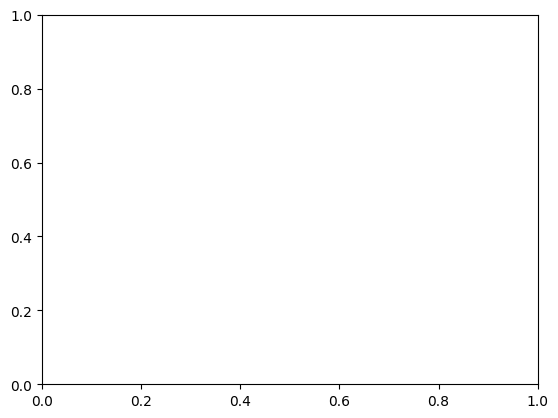

In [10]:
# print solution
print(to.interpolated_thresholder_)

# plot solution
plot_threshold_optimizer(to)

For African-American defendants the decision threshold is randomized between approximately 0.58 ($p=0.66$) and 0.53 ($p=0.33$). For Caucasian defendants the `ThresholdOptimizer` randomizes between a decision threshold of 0.48 ($p=0.991$) and 0.45 ($p=0.008$).

## Adversarial Learning using `AdversarialFairnessClassifier`

Another technique to enforce fairness constraints is adversarial learning. The class `AdversarialFairnessClassifier` is based on the algorithm introduced by [Zhang et al. (2018)]( https://dl.acm.org/doi/pdf/10.1145/3278721.3278779).

```{admonition} Fairness-aware Adversarial Learning
`AdversarialFairnessClassifier` leverages an adversarial learning framework to enforce a fairness constraint. The framework consists of two neural networks: a predictor model, which is designed to accurately predict the target variable, and an adversarial model, which is designed to predict the violation of a fairness constraint. The loss of the predictor model is penalized if the adversarial model performs well.
 
The authors introduce two variations of the framework, that optimize for either demographic parity or equalized odds. When the goal is to achieve demographic parity, the adversary is designed to predict sensitive feature  based on the predicted probabilities of the predictor model. When the goal is to achieve equalized odds, the adversary must predict the sensitive feature,taking as input both the predicted probabilities and the ground-truth variable.
```

The `AdvesarialFairnessClassifier` has various parameters, including:
* `backend`: the deep learning library of choice, either pytorch or tensorflow.
* `predictor_model`: the definition of the predictor model, either a predefined neural network model object or a list in which each value indicates the number of nodes or an activation function
* `adversarial_model`: the definition of the adversarial model, defined in the same way as the predictor_model
* `constraints`: the fairness constraint of choice, either `'equalized_odds'` or `'demographic_parity'`
* `batch_size`: the batch size is the number of samples that will be passed through to the network at each training step

The class has several more parameters that control training. The methods of the `AdvesarialFairnessClassifier` are similar to the familiar scikit-learn API - this time no sensitive features are required at prediction time!

Let's try a simple adversarial network on the COMPAS dataset. We use a simple predictor model with one hidden layer of 50 nodes and a leaky ReLu activation function. The adversary model has 3 nodes and also uses the leaky ReLu activation function.

In [ ]:
# train adversarial fairness classifier
afc = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[50, "leaky_relu"],
    adversary_model=[3, "leaky_relu"],
    constraints='equalized_odds',
    batch_size=8,
    random_state=42
)
afc.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# score
score(
    y_train,
    afc.predict(X_train),
    y_val,
    afc.predict(X_val),
    sensitive_features_train,
    sensitive_features_val,
)

The adversarial classifier performs better in terms of equalized odds compared to the unconstrained logistic regression classifier. However, the drop in equalized odds is not comparable to decision threshold selection and remains very high - with similar accuracy to the decision thresholds.

However, we did not perform any hyperparameter tuning - there might be another configuration that performs better on this data set. Deep learning models are very flexible. For example, we could try more (or less!) complex predictor and adversary models and adjust other hyperparameters such as the learning rate and batch size.

## Concluding Remarks
In this tutorial we have showcased two ways in which we can use fairness-aware machine learning algorithms to post-process a machine learning model. In particular, we considered:
* post-processing predictions through manually identifying a group-specific decision threshold
* post-processing predictions through automatically identifying the optimal randomized group-specific decision thresholds using `ThresholdOptimizer`

### Discussion Points

#### Connection to fairness metrics
* Fairness-aware pre-processing algorithms typically optimize for demographic parity, not for equalized odds or equal calibration. Can you explain why?
* How does post-processing for equalized odds affects other notions of fairness, such as equal calibration and demographic parity? As an exercise, compute fairness metrics that represent alternative notions of (group) fairness. Can you explain the results?

#### The justification of fair-ml
* Our manual choice of the decision threshold uses a different decision threshold for African-Americans than for Caucasians. Under which circumstances would you deem such a policy fair, if any? Why?
* The post-processing algorithm implemented in `ThresholdOptimizer` uses randomization in order to achieve equalized odds. Consequently, individuals with the exact same characteristics may receive a different prediction. Under which circumstances would you deem such a policy fair, if any? Why?

#### Beyond fair-ml
* In this tutorial, we have focussed on technical approaches to optimize for equalized odds. Can you think of other actions in the machine learning development process that could be used to enhance the predictive performance across groups or mitigate historical bias, e.g., during problem formulation and data collection?
* In the United States, pretrial risk assessment tools are not used for automated decision-making. Instead, they are used as decision support for judges. Does this influence the way in which you would evaluate the fairness of a model in practice? Why (not)?